# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

Para este proyecto que consta de varios datasets, mi manera de analizar sera: <br>
- Cargar las librerias necesarias, y proceder a cargar los distintos archivos para su posterior visualizacion <br>
- Realizar la visualizacion general de los tipos de datos contenidos, y cuantos datos no-nulos existen por Dataset. <br>
- En caso de encontrar discrepancias (tanto datos nulos o no validos, como datos duplicados), proceder a la limpieza de los mismos para su posterior analisis.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from scipy import stats as st
from math import factorial
import seaborn as sns
from matplotlib import pyplot as plt

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_users = pd.read_csv('/datasets/megaline_users.csv')
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_plans = pd.read_csv('/datasets/megaline_plans.csv')

 Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
print(df_plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


### Corregir datos

Para este punto, lo que puedo ver para las 2 filas y las 8 columnas es que, los datos se encuentran completos (no hay datos nulos). Respecto a datos duplicados tampoco veo que existan, solo el tema de que, la columna "plan_name" aparece hasta el final del dataset, y yo considero importante que sea la primera columna (dado que es la columna sobre la cual, dependen las siguientes columnas). Y tambien la discrepancia

Para este punto mediante .info(), noto que los datos estan en su forma correcta, y que no existen datos duplicados y/o nulos. <br>
En este punto, analizando las columnas del dataset "plans", solo veo que la columna "plan_name" se localiza en la posicion (-1), procedi a recorrerlo a la posicion (0).

In [5]:
# Reorden de columna "plan_name" al principio del dataset
col = df_plans.pop('plan_name')
df_plans.insert(0, "plan_name", col)

### Enriquecer los datos

Existe una discrepancia entre los mb incluidos por mes, y el cobro por gb (no esta homologado). 

In [6]:
# Agregar columna "gb_per_month_included" para homologar los datos incluidos, y el precio por datos extras.
df_plans['gb_per_month_included'] = df_plans['mb_per_month_included'] / 1024
df_plans['gb_per_month_included'] = df_plans['gb_per_month_included'].astype(int)

In [7]:
# Remover columna "mb_per_month_included"
del df_plans["mb_per_month_included"]

In [8]:
# Imprime una muestra de los datos para las tarifas
col_gb = df_plans.pop("gb_per_month_included")
df_plans.insert(1, "gb_per_month_included", col_gb)
print(df_plans.head())

  plan_name  gb_per_month_included  messages_included  minutes_included  \
0      surf                     15                 50               500   
1  ultimate                     30               1000              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  
0               20          10             0.03            0.03  
1               70           7             0.01            0.01  


## Usuarios/as

In [9]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [10]:
# Imprime una muestra de datos para usuarios
# print(df_users.head())
# print()
print(df_users.sample(10))

     user_id first_name   last_name  age  \
366     1366        Rod        Huff   62   
344     1344       Hugo   Daugherty   70   
365     1365    Milford        Rush   19   
152     1152    Merrill       Hogan   35   
245     1245      Quinn       David   30   
408     1408     Alaine   Robertson   40   
79      1079      Brian      Mccall   48   
92      1092      Taren  Strickland   26   
268     1268     Britni      Bowers   33   
394     1394  Alejandro      Carver   28   

                                          city    reg_date  plan churn_date  
366                   Cincinnati, OH-KY-IN MSA  2018-07-30  surf        NaN  
344  New York-Newark-Jersey City, NY-NJ-PA MSA  2018-12-25  surf        NaN  
365              Grand Rapids-Kentwood, MI MSA  2018-02-09  surf        NaN  
152          Orlando-Kissimmee-Sanford, FL MSA  2018-11-01  surf        NaN  
245  New York-Newark-Jersey City, NY-NJ-PA MSA  2018-06-19  surf        NaN  
408          Baltimore-Columbia-Towson, MD MSA 

Mediante el uso de info(), puedo observar un par de cuestiones: primero, el tipo de datos almacenados en cada columna. Las columnas "reg_date" y "churn_date" estan bajo (object), y deben estar bajo (datetime). Ademas, Existen valores ausentes en la columna "churn_date". 

### Corregir los datos

Revisando los valores ausentes en la columna "churn_date", podemos concluir que, esto es debido a que los usuarios que tengan esa columna vacia pertenecen a miembros activos. <br>
Tambien revisar que el user_id sea unico, dado que no deberia existir un valor duplicado en esa columna.

In [11]:
# Corregir el tipo de dato de las columnas "reg_date" y "churn_date" a datetime
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])

# Renombrar la columna "plan" para estar homologado con la columna "plan_name" del dataset plans. 
df_users.rename(columns={"plan": "plan_name"}, inplace= True)

# Revisar si existen datos duplicados
print("IDs duplicados: ", df_users['user_id'].duplicated().sum())
print()

# Revisar la cantidad de usuarios activos y no activos, dado los valores de la columna "churn_date"
print("Usuarios activos:", df_users['churn_date'].isnull().sum())
print("Usuarios que cancelaron:", df_users['churn_date'].notnull().sum())
print()

df_users.info()

IDs duplicados:  0

Usuarios activos: 466
Usuarios que cancelaron: 34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan_name   500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enriquecer los datos

Para este punto, podemos observar que la cantidad de usuarios que se encuentran activos (tomando como referencia los valores nulos y no nulos) son 466; <br>
mientras que los usuarios que cancelaron su suscripcion son 34. <br>
Como es importante no modificar los datos nulos y no nulos de la columna "churn_date", procedo a agregar una nueva columna tomando como parametro esos datos de esa columna. <br>
Tambien, se modifico los tipos de datos para las columnas reg_date y churn_date.

In [12]:
# Agregar columna que toma como referencia si existe un valor nulo o no nulo en la columna "churn_date"
df_users["user_active"] = np.where(df_users["churn_date"].isna(), "active", "no active")
print(df_users.sample(5))
print()
df_users.info()

     user_id first_name last_name  age  \
320     1320       Bert     Wells   23   
217     1217        Ned    Thomas   69   
95      1095    Lilliam  Alvarado   55   
282     1282     Annice   Calhoun   61   
17      1017      Boris     Gates   61   

                                                 city   reg_date plan_name  \
320            Los Angeles-Long Beach-Anaheim, CA MSA 2018-02-23      surf   
217                          Dayton-Kettering, OH MSA 2018-06-04      surf   
95             Louisville/Jefferson County, KY-IN MSA 2018-04-21      surf   
282            San Francisco-Oakland-Berkeley, CA MSA 2018-11-01  ultimate   
17   Washington-Arlington-Alexandria, DC-VA-MD-WV MSA 2018-08-26      surf   

    churn_date user_active  
320        NaT      active  
217        NaT      active  
95         NaT      active  
282        NaT      active  
17         NaT      active  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):

## Llamadas

In [13]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [14]:
# Imprime una muestra de datos para las llamadas
# print(df_calls.head(10))
# print()
print(df_calls.sample(10))

              id  user_id   call_date  duration
122312  1432_162     1432  2018-10-08     13.63
72935   1257_675     1257  2018-07-16      5.15
57564   1206_385     1206  2018-09-10     14.95
119684  1417_256     1417  2018-12-02      4.69
95539   1338_361     1338  2018-08-20      5.47
66043   1239_126     1239  2018-10-26      5.26
53447   1192_200     1192  2018-12-03      2.47
99722    1358_38     1358  2018-05-15      4.93
65496   1237_103     1237  2018-12-23      9.41
2333    1009_755     1009  2018-05-19      4.32


A primera vista, con la impresion de los tipos de datos y el muestreo del dataset, noto que la columna "id" se encuntra como object, y la columna "call_date" aparece tambien como object, siendo que deberia ser datetime. 

### Corregir los datos

Para este punto, agregando los comentarios anteriores, procedemos a revisar si existen como tal valores nulos y valores duplicados, dado que en la columna "id", no deberian existir valores duplicados.

In [15]:
print("IDs duplicados: ", df_calls['id'].duplicated().sum())
print("IDs nulos: ", df_calls['id'].isnull().sum())
print()

df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls.info()

IDs duplicados:  0
IDs nulos:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enriquecer los datos

Dadas las instrucciones, donde Megaline redondea los segundos a minutos, se necesita redondear los valores en la columna "duration" para que todas queden como minutos. <br>
Tambien, como los datos deben ser mostrados para mas adelante analizar (por mes), se crea una nueva columna, tomando el mes de la columna "call_date".

In [16]:
# Redondear la duracion de llamadas (de segundos a minutos), y convertir el tipo de datos a Int. 
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
df_calls['month'] = df_calls['call_date'].dt.month

print(df_calls.head(10))

         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27         9     12
1  1000_145     1000 2018-12-27        14     12
2  1000_247     1000 2018-12-27        15     12
3  1000_309     1000 2018-12-28         6     12
4  1000_380     1000 2018-12-30         5     12
5  1000_388     1000 2018-12-31         3     12
6  1000_510     1000 2018-12-27         6     12
7  1000_521     1000 2018-12-28        15     12
8  1000_530     1000 2018-12-28         6     12
9  1000_544     1000 2018-12-26         5     12


## Mensajes

In [17]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [18]:
# Imprime una muestra de datos para los mensajes
# print(df_messages.head(10))
# print()
print(df_messages.sample(10))

             id  user_id message_date
29834  1183_229     1183   2018-10-22
26869  1164_119     1164   2018-10-27
6686    1057_10     1057   2018-10-29
68364  1440_230     1440   2018-09-10
14802  1100_124     1100   2018-08-22
25878  1155_263     1155   2018-11-22
54749  1346_253     1346   2018-10-11
21490  1132_852     1132   2018-05-22
30983  1194_142     1194   2018-10-30
11663   1079_62     1079   2018-10-30


Para el caso de df_messages, con la impresion del tipo de datos y valores nulos se puede observar que, el tipo de datos de la columna "message_date" aparece como object.

### Corregir los datos

In [19]:
# Revisar si existen datos duplicados en la columna "id"
print("IDs duplicados: ", df_messages['id'].duplicated().sum())
print("IDs nulos: ", df_messages['id'].isnull().sum())
print()

df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages.info()

IDs duplicados:  0
IDs nulos:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

Dados los valores que ya tenemos en las columnas del dataset df_messages, para futuro analisis solo se procede a agregar una columna donde nos devuelva el mes, tomando como referencia la columna "message_date". 

In [20]:
# Agregar la columna "month", tomando como referencia el mes de la columna "message_date"
df_messages['month'] = df_messages['message_date'].dt.month
print(df_messages.sample(10))

             id  user_id message_date  month
27499  1169_895     1169   2018-12-16     12
37818   1250_71     1250   2018-11-21     11
59003  1374_177     1374   2018-10-29     10
31673  1196_157     1196   2018-07-26      7
526    1004_220     1004   2018-07-06      7
75526  1491_400     1491   2018-11-23     11
53960   1343_41     1343   2018-12-27     12
27942  1172_399     1172   2018-12-25     12
7540   1059_423     1059   2018-11-01     11
42866   1281_67     1281   2018-08-23      8


## Internet

In [21]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [22]:
# Imprime una muestra de datos para el tráfico de internet
# print(df_internet.head(10))
# print()
print(df_internet.sample(10))

             id  user_id session_date  mb_used
50724  1226_205     1226   2018-09-16   298.55
18686  1083_288     1083   2018-11-19   200.61
58886  1264_307     1264   2018-08-25    66.44
16676   1076_35     1076   2018-10-05   335.10
85328   1398_85     1398   2018-11-05    60.83
44474  1196_487     1196   2018-04-18   446.02
77357   1362_24     1362   2018-05-14    64.79
65927  1305_107     1305   2018-10-23   143.28
38979  1174_242     1174   2018-10-10   731.70
63622  1292_326     1292   2018-08-27   346.55


Para este dataset, existen un par de cuestiones a revisar. <br>
primeramente, el tipo de datos en la columna "session_date", aparece como object. Se tiene que transformar a datetime <br>
la columna de mb_used, dadas la descripcion de las tarifas necesita transformarse primeramente a gb <br>
finalmente, para posterior analisis en rango mensual, se necesita agregar una columna donde se tome como referencia la columna "session_date" para devolver el mes.

### Corregir los datos

In [23]:
# Revisar si existen datos duplicados en la columna "id"
print("IDs duplicados: ", df_internet['id'].duplicated().sum())
print("IDs nulos: ", df_internet['id'].isnull().sum())
print()

# Transformar el tipo de dato object a datetime
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

df_internet.info()

IDs duplicados:  0
IDs nulos:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

In [24]:
# transformar valores de "mb" a "gb" y asignarlo a una nueva columna "gb_used". Redondear valores y transformar a tipo Int.
df_internet['gb_used'] = df_internet['mb_used'] / 1024

# Agregar la columna "month", tomando como referencia el mes de la columna "session_date"
df_internet['month'] = df_internet['session_date'].dt.month
print(df_internet.sample(10))

              id  user_id session_date  mb_used   gb_used  month
11203   1055_208     1055   2018-09-25   537.80  0.525195      9
101712   1488_59     1488   2018-07-14   806.98  0.788066      7
50994    1228_89     1228   2018-11-30   334.18  0.326348     11
76664   1359_351     1359   2018-05-13   759.84  0.742031      5
19758    1089_38     1089   2018-12-29   951.32  0.929023     12
24005   1110_263     1110   2018-08-04   528.42  0.516035      8
36893    1166_59     1166   2018-11-19   272.92  0.266523     11
76737   1359_426     1359   2018-10-02   446.79  0.436318     10
5314    1029_110     1029   2018-12-23   309.53  0.302275     12
46016   1203_341     1203   2018-06-04   233.50  0.228027      6


## Estudiar las condiciones de las tarifas

In [25]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print(df_plans.head())

  plan_name  gb_per_month_included  messages_included  minutes_included  \
0      surf                     15                 50               500   
1  ultimate                     30               1000              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  
0               20          10             0.03            0.03  
1               70           7             0.01            0.01  


 ### Agregar datos por usuario

In [26]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
user_monthly_calls = df_calls.groupby(['user_id', 'month']).agg(
    total_calls = ('duration', 'count')
).reset_index()

# Imprimir el resultado
print(user_monthly_calls.head(10))

   user_id  month  total_calls
0     1000     12           16
1     1001      8           27
2     1001      9           49
3     1001     10           65
4     1001     11           64
5     1001     12           56
6     1002     10           11
7     1002     11           55
8     1002     12           47
9     1003     12          149


In [27]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
user_monthly_minutes = df_calls.groupby(['user_id', 'month']).agg(
    total_minutes = ('duration', 'sum')
).reset_index()

# Imprimir el resultado
print(user_monthly_minutes.head())

   user_id  month  total_minutes
0     1000     12            124
1     1001      8            182
2     1001      9            315
3     1001     10            393
4     1001     11            426


In [28]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
user_monthly_messages = df_messages.groupby(['user_id', 'month']).agg(
    total_messages = ('id', 'count')
).reset_index()

# Imprimir el resultado
print(user_monthly_messages.head())

   user_id  month  total_messages
0     1000     12              11
1     1001      8              30
2     1001      9              44
3     1001     10              53
4     1001     11              36


In [29]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
user_monthly_gb = df_internet.groupby(['user_id', 'month']).agg(
    total_data_gb = ('gb_used', 'sum')
).reset_index()

# Siguiendo los criterios de las tarifas, redondeamos los gb.
user_monthly_gb['total_data_gb'] = np.ceil(user_monthly_gb['total_data_gb']).astype(int)
print(user_monthly_gb.head())


   user_id  month  total_data_gb
0     1000     12              2
1     1001      8              7
2     1001      9             14
3     1001     10             22
4     1001     11             19


In [30]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
merged_user_monthly_data = user_monthly_calls.merge(user_monthly_minutes, on= ['user_id', 'month'], how= 'outer')
merged_user_monthly_data = merged_user_monthly_data.merge(user_monthly_messages, on= ['user_id', 'month'], how= 'outer')
merged_user_monthly_data = merged_user_monthly_data.merge(user_monthly_gb, on= ['user_id', 'month'], how= 'outer')

# Cambiar el tipo de datos a int y rellenar valores nulos a 0.
merged_user_monthly_data['total_calls'] =  merged_user_monthly_data['total_calls'].fillna(0).astype(int)
merged_user_monthly_data['total_minutes'] =  merged_user_monthly_data['total_minutes'].fillna(0).astype(int)
merged_user_monthly_data['total_messages'] =  merged_user_monthly_data['total_messages'].fillna(0).astype(int)
merged_user_monthly_data['total_data_gb'] =  merged_user_monthly_data['total_data_gb'].fillna(0).astype(int)

# Imprimir los valores
merged_user_monthly_data.info()
print()
print(merged_user_monthly_data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         2293 non-null   int64
 1   month           2293 non-null   int64
 2   total_calls     2293 non-null   int64
 3   total_minutes   2293 non-null   int64
 4   total_messages  2293 non-null   int64
 5   total_data_gb   2293 non-null   int64
dtypes: int64(6)
memory usage: 125.4 KB

   user_id  month  total_calls  total_minutes  total_messages  total_data_gb
0     1000     12           16            124              11              2
1     1001      8           27            182              30              7
2     1001      9           49            315              44             14
3     1001     10           65            393              53             22
4     1001     11           64            426              36             19


In [31]:
# Añade la información de la tarifa
full_user_monthly_data = merged_user_monthly_data.merge(df_users[['user_id', 'city', 'plan_name']], on='user_id', how='left')
full_user_monthly_data = full_user_monthly_data.merge(df_plans[['plan_name', 'minutes_included', 'messages_included', 'gb_per_month_included', 'usd_monthly_pay', 
                                                                'usd_per_minute', 'usd_per_message', 'usd_per_gb']], on='plan_name', how='left')

# Reajustar el orden de columnas "plan_name" y "usd_monthly_pay"
col_users = full_user_monthly_data.pop('plan_name')
full_user_monthly_data.insert(1, 'plan_name', col_users)

col_pay = full_user_monthly_data.pop('usd_monthly_pay')
full_user_monthly_data.insert(2, 'usd_monthly_pay', col_pay)

# Imprimir el resultado
print(full_user_monthly_data)

      user_id plan_name  usd_monthly_pay  month  total_calls  total_minutes  \
0        1000  ultimate               70     12           16            124   
1        1001      surf               20      8           27            182   
2        1001      surf               20      9           49            315   
3        1001      surf               20     10           65            393   
4        1001      surf               20     11           64            426   
...       ...       ...              ...    ...          ...            ...   
2288     1349      surf               20     12            0              0   
2289     1361      surf               20      5            0              0   
2290     1482  ultimate               70     10            0              0   
2291     1108  ultimate               70     12            0              0   
2292     1311  ultimate               70      6            0              0   

      total_messages  total_data_gb  \
0           

In [32]:
# Calcular el ingreso mensual.
full_user_monthly_data[['total_minutes', 'total_messages', 'total_data_gb']] = full_user_monthly_data[['total_minutes', 'total_messages', 'total_data_gb']].fillna(0)

def calculate_revenue(row):
    revenue = row['usd_monthly_pay']
    
    # Ingresos por minutos extra
    extra_minutes = row['total_minutes'] - row['minutes_included']
    if extra_minutes > 0:
        revenue += extra_minutes * row['usd_per_minute']
    
    # Ingresos por mensajes extra
    extra_messages = row['total_messages'] - row['messages_included']
    if extra_messages > 0:
        revenue += extra_messages * row['usd_per_message']
    
    # Ingresos por gigabytes extra
    extra_gb = row['total_data_gb'] - row['gb_per_month_included']
    if extra_gb > 0:
        revenue += extra_gb * row['usd_per_gb']
    
    return revenue

# Aplica la función fuera de la definición
full_user_monthly_data['monthly_revenue'] = full_user_monthly_data.apply(calculate_revenue, axis=1)
print(full_user_monthly_data.head(5))

   user_id plan_name  usd_monthly_pay  month  total_calls  total_minutes  \
0     1000  ultimate               70     12           16            124   
1     1001      surf               20      8           27            182   
2     1001      surf               20      9           49            315   
3     1001      surf               20     10           65            393   
4     1001      surf               20     11           64            426   

   total_messages  total_data_gb                                   city  \
0              11              2  Atlanta-Sandy Springs-Roswell, GA MSA   
1              30              7        Seattle-Tacoma-Bellevue, WA MSA   
2              44             14        Seattle-Tacoma-Bellevue, WA MSA   
3              53             22        Seattle-Tacoma-Bellevue, WA MSA   
4              36             19        Seattle-Tacoma-Bellevue, WA MSA   

   minutes_included  messages_included  gb_per_month_included  usd_per_minute  \
0          

## Estudia el comportamiento de usuario

### Llamadas

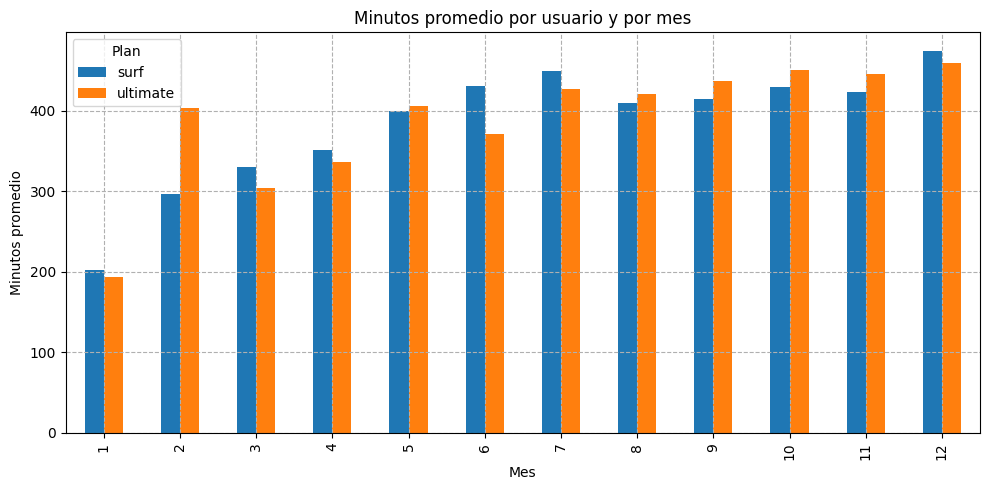

In [33]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. 
calls_by_plan = full_user_monthly_data.groupby(['plan_name','month'])['total_minutes'].agg(['mean', 'var', 'std']).reset_index()

# Traza un gráfico de barras para visualizarla.
pivot_calls = calls_by_plan.pivot(index='month', columns='plan_name', values='mean')
pivot_calls.plot(kind='bar', figsize=(10,5), title='Minutos promedio por usuario y por mes')
plt.xlabel('Mes')
plt.grid(True, linestyle='--')
plt.ylabel('Minutos promedio')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

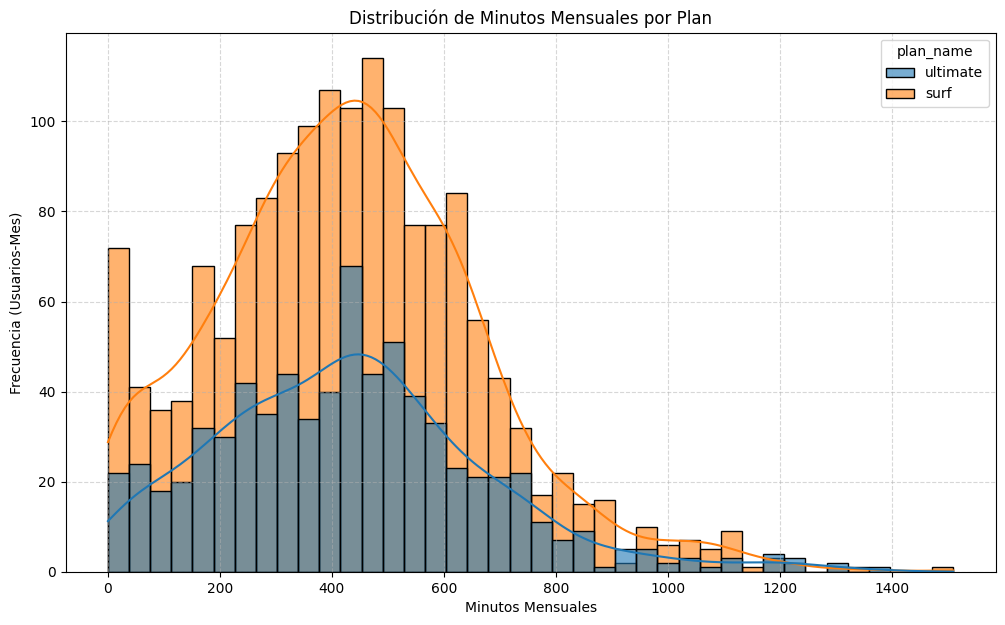

In [34]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. 
plt.figure(figsize=(12, 7))

sns.histplot(
    data=full_user_monthly_data,
    x='total_minutes',
    hue='plan_name',
    kde=True,
    alpha=0.6,
    bins=40
)

plt.title('Distribución de Minutos Mensuales por Plan')
plt.xlabel('Minutos Mensuales')
plt.ylabel('Frecuencia (Usuarios-Mes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [35]:
# Calcula la media y la varianza de la duración mensual de llamadas.
desc_calls = (full_user_monthly_data
              .groupby('plan_name')['total_minutes']
              .agg(['count','mean','median','var','std','min','max'])
              .round(2))
print(desc_calls)

           count    mean  median       var     std  min   max
plan_name                                                    
surf        1573  428.75     425  54968.28  234.45    0  1510
ultimate     720  430.45     424  57844.46  240.51    0  1369


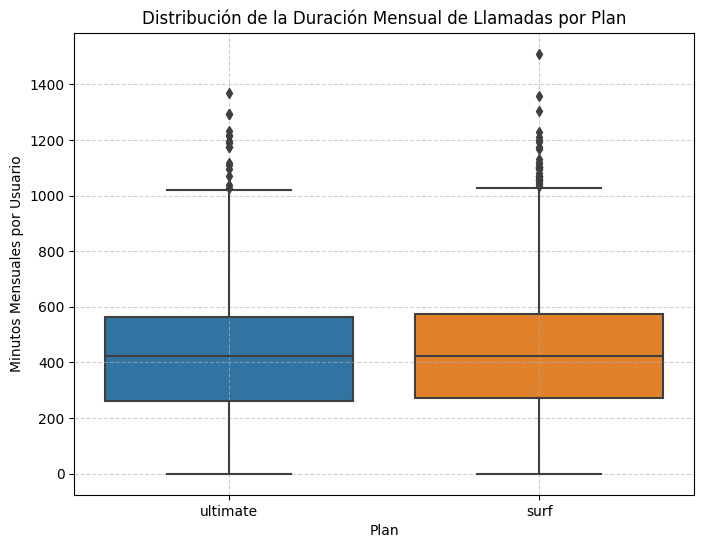

In [36]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
plt.figure(figsize=(8, 6))
sns.boxplot(data=full_user_monthly_data, x='plan_name', y='total_minutes')

plt.title('Distribución de la Duración Mensual de Llamadas por Plan')
plt.xlabel('Plan')
plt.ylabel('Minutos Mensuales por Usuario')
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar el gráfico
plt.show()

Respecto a la variacion entre los usuarios y su tipo de plan, realmente no se nota una diferencia notable. Por lo que, puedo decir que es minima esa diferencia

### Mensajes

In [37]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
messages_desc = (full_user_monthly_data
                 .groupby('plan_name')['total_messages']
                 .agg(['count', 'mean', 'median', 'var', 'std', 'min', 'max'])
                 .round(2))

print("Estadísticas descriptivas para mensajes mensuales:")
print()
print(messages_desc)

Estadísticas descriptivas para mensajes mensuales:

           count   mean  median      var    std  min  max
plan_name                                                
surf        1573  31.16      24  1126.72  33.57    0  266
ultimate     720  37.55      30  1208.76  34.77    0  166


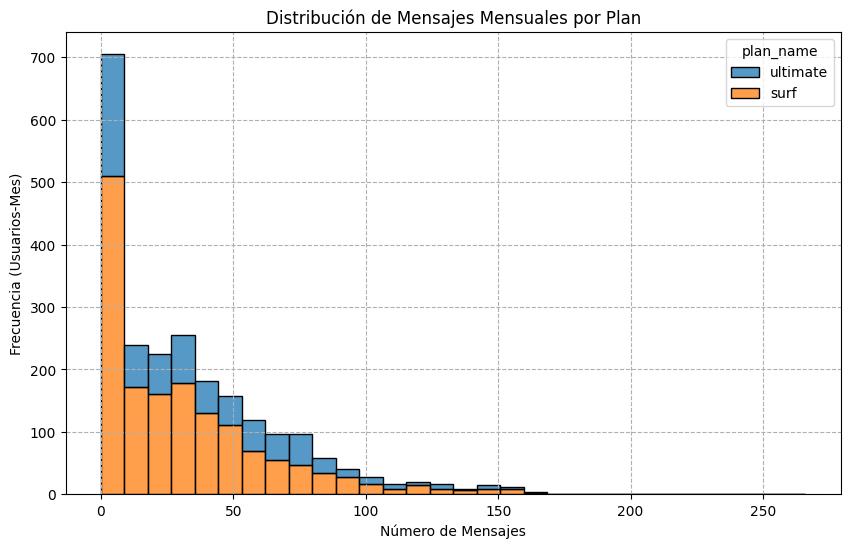

In [38]:
# Traza un gráfico de barras para visualizarla.
plt.figure(figsize=(10, 6))
sns.histplot(data=full_user_monthly_data, x='total_messages', hue='plan_name', multiple='stack', bins=30)
plt.title('Distribución de Mensajes Mensuales por Plan')
plt.xlabel('Número de Mensajes')
plt.ylabel('Frecuencia (Usuarios-Mes)')
plt.grid(True, linestyle='--')
plt.show()

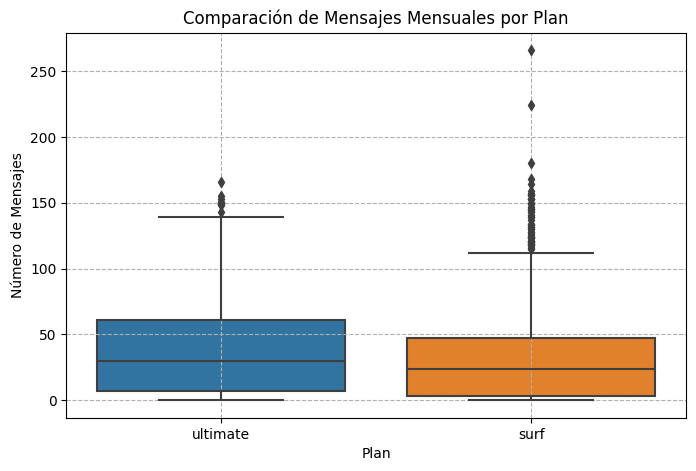

In [39]:
# Diagrama de caja para mensajes
plt.figure(figsize=(8, 5))
sns.boxplot(data=full_user_monthly_data, x='plan_name', y='total_messages')
plt.title('Comparación de Mensajes Mensuales por Plan')
plt.xlabel('Plan')
plt.ylabel('Número de Mensajes')
plt.grid(True, linestyle='--')
plt.show()

Mi conclusion respecto al apartado de los mensajes es que, estadisticamente podemos ver que, en promedio, los usuarios del plan Ultimate envian mas que los del plan surf. <br>
respecto al tema de los graficos, se puede apreciar que la mayoria de los usuarios de ambos planes envian menos de 50 mensajes, siendo este el limite del plan Surf, pero para el plan Ultimate muy pocos tienden a llegar a su limite de 1000 mensajes. 

### Internet

In [40]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
internet_desc = (full_user_monthly_data
                 .groupby('plan_name')['total_data_gb']
                 .agg(['count', 'mean', 'median', 'var', 'std', 'min', 'max'])
                 .round(2))

print("Estadísticas descriptivas para consumo mensual de GB:")
print(internet_desc)

Estadísticas descriptivas para consumo mensual de GB:
           count   mean  median    var   std  min  max
plan_name                                             
surf        1573  16.67      17  61.58  7.85    0   70
ultimate     720  17.31      17  58.83  7.67    0   46


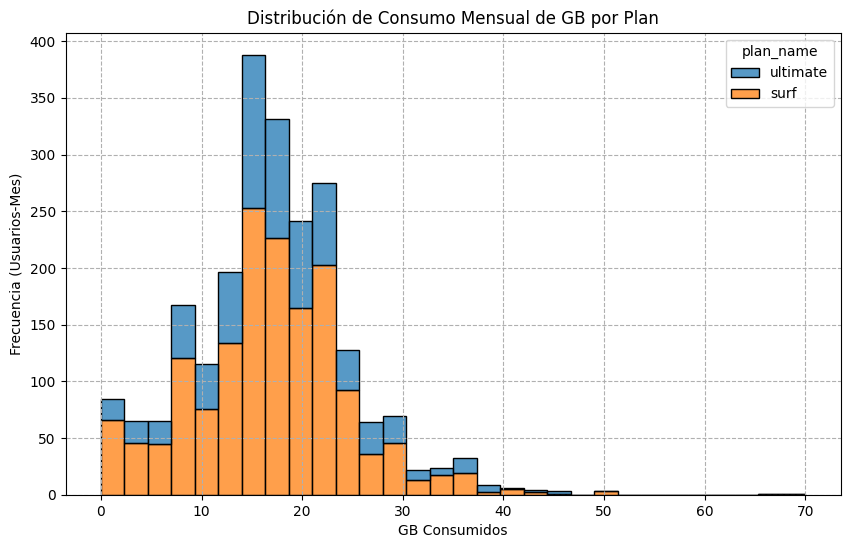

In [41]:
# Histograma para el consumo de datos
plt.figure(figsize=(10, 6))
sns.histplot(data=full_user_monthly_data, x='total_data_gb', hue='plan_name', multiple='stack', bins=30)
plt.title('Distribución de Consumo Mensual de GB por Plan')
plt.xlabel('GB Consumidos')
plt.ylabel('Frecuencia (Usuarios-Mes)')
plt.grid(True, linestyle='--')
plt.show()

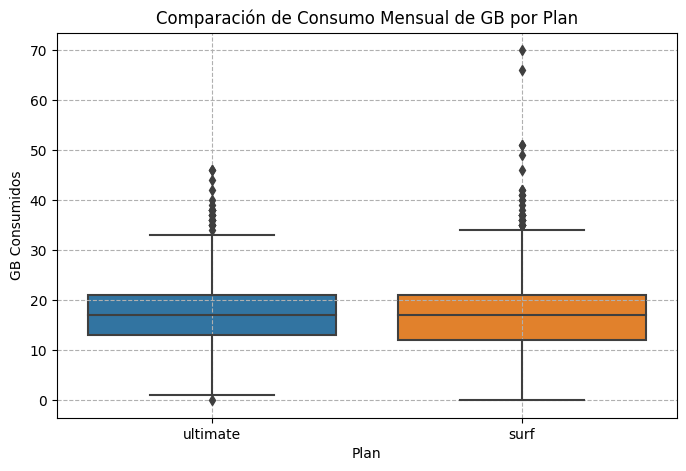

In [42]:
# Diagrama de caja para el consumo de datos
plt.figure(figsize=(8, 5))
sns.boxplot(data=full_user_monthly_data, x='plan_name', y='total_data_gb')
plt.title('Comparación de Consumo Mensual de GB por Plan')
plt.xlabel('Plan')
plt.ylabel('GB Consumidos')
plt.grid(True, linestyle='--')
plt.show()

Respecto al tema de internet, podemos ver una variacion mayor (en proporcion a sus limites de datos) en los usuarios de ambos planes. En el caso de Surf, tienden a exceder mas su limite de datos incluidos, teniendo usuarios cuyos datos que llegan a los 70gb. Se muestran un poco equilibrados los usuarios para ambos planes, pero considerando sus limites, valdria la pena explorar mas el porque los clientes de surf tienden a exceder su plan de datos. 

## Ingreso

In [43]:
# Estadísticos por plan
revenue_desc = (full_user_monthly_data
                .groupby('plan_name')['monthly_revenue']
                .agg(['count','mean','median','var','std','min','max'])
                .round(2))
print(revenue_desc)

           count   mean  median      var    std   min     max
plan_name                                                    
surf        1573  60.71   40.36  3067.84  55.39  20.0  590.37
ultimate     720  72.31   70.00   129.85  11.40  70.0  182.00


In [44]:
# Separacion de los datos por plan
surf_data = full_user_monthly_data[full_user_monthly_data['plan_name'] == 'surf']
ultimate_data = full_user_monthly_data[full_user_monthly_data['plan_name'] == 'ultimate']

# Promedio mensual por plan
revenue_mean = (full_user_monthly_data
                .groupby(['plan_name','month'])['monthly_revenue']
                .mean()
                .reset_index())

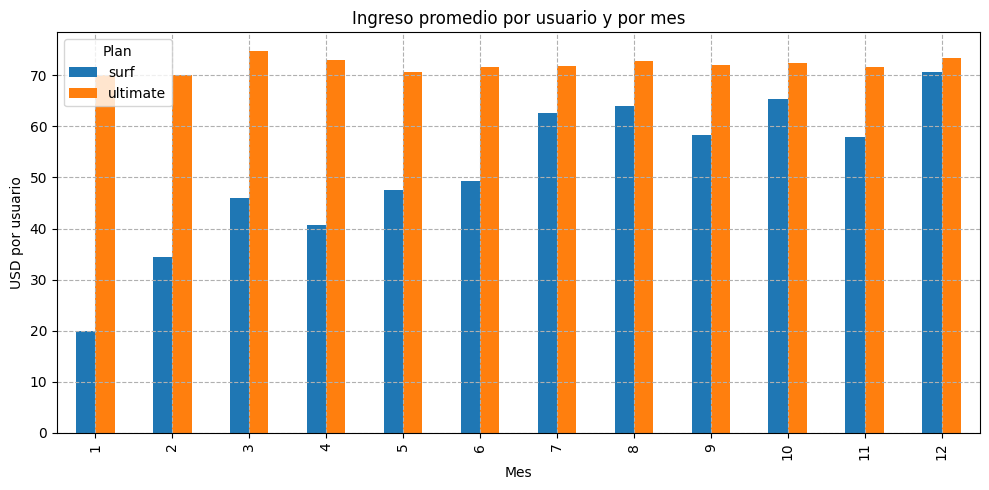

In [45]:
# Geneeracion de una grafica de barras para mostrar visualmente la diferencia entre los tipos de plan
pivot_rev = revenue_mean.pivot(index='month', columns='plan_name', values='monthly_revenue')
pivot_rev.plot(kind='bar', figsize=(10,5), title='Ingreso promedio por usuario y por mes')
plt.xlabel('Mes')
plt.ylabel('USD por usuario')
plt.grid(True, linestyle='--')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

Dados los resultados de la grafica, podriamos decir que existe un mayor ingreso promedio del plan "ultimate" sobre el plan "surf". Notando esa diferencia en todos los meses

## Prueba las hipótesis estadísticas

Hipótesis nula: El ingreso promedio de los usuarios de los planes Ultimate y Surf es igual. <br>
Hipótesis alternativa: El ingreso promedio de los usuarios de los planes Ultimate y Surf es diferente. <br>
Valor alpha: 0.05

In [46]:
# Prueba las hipótesis
# Extraemos los ingresos por tipo de plan.
revenue_surf = surf_data['monthly_revenue']
revenue_ultimate = ultimate_data['monthly_revenue']
alpha = 0.05

results = st.ttest_ind(revenue_surf, revenue_ultimate, equal_var=False)
print("Prueba de hipótesis: Ingresos de los planes Ultimate y Surf: ")
print('p-value:', results.pvalue)
print()

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula: el ingreso promedio de los planes es significativamente diferente.")
else:
    print("No podemos rechazar la hipótesis nula: no hay suficiente evidencia para decir que el ingreso promedio es diferente.")

Prueba de hipótesis: Ingresos de los planes Ultimate y Surf: 
p-value: 3.1703905481135734e-15

Rechazamos la hipótesis nula: el ingreso promedio de los planes es significativamente diferente.


Dados los resultado de esta primera hipotesis, nos permite rechazar la hipotesis nula, y supone que los ingresos promedio de los 2 planes que existen "Surf" y "Ultimate", son diferentes.

Hipótesis nula: El ingreso promedio de los usuarios de NY-NJ es igual al de otras regiones. <br>
Hipótesis alternativa: El ingreso promedio de los usuarios de NY-NJ es diferente al de otras regiones. <br>
Valor alpha: 0.05

In [47]:
# Prueba las hipótesis
ny_nj_users = full_user_monthly_data[full_user_monthly_data['city'].str.contains('NY-NJ', case=False)]
other_users = full_user_monthly_data[~full_user_monthly_data['city'].str.contains('NY-NJ', case=False)]

# Ahora, separar los ingresos por grupo
revenue_ny_nj = ny_nj_users['monthly_revenue']
revenue_other = other_users['monthly_revenue']
alpha = 0.05

results_region = st.ttest_ind(revenue_ny_nj, revenue_other, equal_var=False)
print("Prueba de hipótesis: Ingresos de usuarios de NY-NJ vs. otras regiones: ")
print('p-value:', results_region.pvalue)
print()

if results_region.pvalue < alpha:
    print("Rechazamos la hipótesis nula: el ingreso promedio de los usuarios de NY-NJ es significativamente diferente al de otras regiones.")
else:
    print("No podemos rechazar la hipótesis nula: no hay suficiente evidencia para decir que el ingreso promedio es diferente.")

Prueba de hipótesis: Ingresos de usuarios de NY-NJ vs. otras regiones: 
p-value: 0.0335256158853001

Rechazamos la hipótesis nula: el ingreso promedio de los usuarios de NY-NJ es significativamente diferente al de otras regiones.


Dados los resultado de esta primera hipotesis, nos permite rechazar la hipotesis nula, y supone que los ingresos de la region de NY-NJ son altamente diferentes al resto de regiones.

## Conclusión general


El proyecto buscaba determinar cuál de los dos planes de prepago, Surf o Ultimate, genera un mayor ingreso promedio por cliente para la operadora Megaline, con el fin de orientar el presupuesto publicitario. <br>
<br>
Comenzamos con el preprocesamiento de datos. <br>
<br>
Se realizó una limpieza y transformación detallada de los datos provenientes de cinco fuentes distintas (usuarios, llamadas, mensajes, internet, planes).<br>
Las tareas clave incluyeron la corrección de tipos de datos, manejo de valores nulos, conversión de MB a GB, y la aplicación de las reglas de redondeo de Megaline para minutos de llamada y GB de datos consumidos mensualmente. <br>
Se agregaron los datos de consumo (minutos, mensajes, GB) por usuario y por mes. <br>
Finalmente, se calculó el ingreso mensual (monthly_revenue) para cada usuario, considerando la tarifa base del plan y los cargos adicionales por exceder los límites incluidos. <br>
<br>
Analisis del comportamiento de los usuarios:
<br>
El análisis del comportamiento mostró que los usuarios del plan Surf exceden sus límites (especialmente de datos) con mucha más frecuencia que los usuarios del plan Ultimate, lo que genera ingresos variables pero a veces significativos por cargos extra. <br>
Los usuarios del plan Ultimate, con límites más altos, rara vez incurren en cargos adicionales, proporcionando un ingreso más predecible y alto por tarifa base.<br>
A pesar de los picos de ingresos por excedentes en el plan Surf, el ingreso promedio mensual por usuario resultó ser consistentemente más alto para el plan Ultimate.<br>
<br>
Para la prueba de hipotesis: <br>
<br>
Se confirmó mediante una prueba t de Student que la diferencia en el ingreso promedio mensual entre los planes Surf y Ultimate es estadísticamente significativa. <br>
También se encontró una diferencia estadísticamente significativa en los ingresos promedio generados por los usuarios de la región NY-NJ en comparación con otras regiones.<br>
<br>
Finalmente, aunque el plan Surf puede generar ingresos altos por usuario cuando se exceden los límites, el plan Ultimate demuestra ser, en promedio, más rentable por cliente para Megaline. Esta conclusión sugiere que el departamento comercial podría enfocar parte del presupuesto publicitario en atraer o retener clientes del plan Ultimate debido a su mayor y más estable contribución a los ingresos promedio.